# Building Segmentation -- UNet + OAM Pretrained Weights

Transfer learning from **OAM-TCD tree canopy weights** (ResNet-50 encoder + full UNet decoder)
to binary building footprint segmentation on OpenAerialMap imagery with OpenStreetMap labels.

**Pretrained weights**: `Unet_Weights.OAM_RGB_RESNET50_TCD`
- Trained on OAM-TCD dataset (5072 images, 280k trees, 10cm/px, RGB)
- UNet + ResNet-50 via SMP, 2-class (background/tree), 1024x1024
- Full model transfer (encoder+decoder), only head re-used as-is for 2-class building task
- Paper: [arxiv.org/abs/2407.11743](https://arxiv.org/abs/2407.11743) (NeurIPS 2024)

In [ ]:
import os
from typing import Literal

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from torchgeo.datasets import OpenAerialMap, OpenStreetMap, stack_samples
from torchgeo.models import Unet_Weights, unet
from torchgeo.samplers import RandomGeoSampler

DEVICE: Literal["cuda", "cpu"] = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

/home/krschap/code/hotosm/fAIr-models/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


## Model -- OAM Pretrained UNet

`unet()` loads **full model** (encoder + decoder + head). Since OAM-TCD weights are 2-class
and buildings are also 2-class (background/building), the entire checkpoint loads with `strict=True`.

In [2]:
model = unet(weights=Unet_Weights.OAM_RGB_RESNET50_TCD, classes=2)
model = model.to(DEVICE)
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [3]:
total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parameters: {total:,} total, {trainable:,} trainable")

weights_meta = Unet_Weights.OAM_RGB_RESNET50_TCD.meta
for k, v in weights_meta.items():
    print(f"  {k}: {v}")

Parameters: 32,521,250 total, 32,521,250 trainable
  dataset: OAM-TCD
  in_chans: 3
  num_classes: 2
  model: U-Net
  encoder: resnet50
  publication: https://arxiv.org/abs/2407.11743
  repo: https://github.com/restor-foundation/tcd
  bands: ['R', 'G', 'B']
  classes: ('background', 'tree-canopy')
  input_shape: (3, 1024, 1024)
  resolution: 0.1
  license: CC-BY-NC-4.0


## Dataset -- OAM Imagery + OSM Building Masks

Downloads OAM tiles for Banepa Municipality, Nepal and intersects with OSM building polygons.
torchgeo's `IntersectionDataset` (`&` operator) ensures spatial alignment.

In [8]:
WORK_DIR = "data/banepa"
os.makedirs(WORK_DIR, exist_ok=True)

BBOX = [85.514668, 27.628367, 85.528875, 27.638514]
OAM_IMAGE_ID = "62d86c65d8499800053796c4"
ZOOM = 19
CHIP_SIZE = 512

oam = OpenAerialMap(
    paths=os.path.join(WORK_DIR, "oam"),
    bbox=BBOX, zoom=ZOOM, image_id=OAM_IMAGE_ID,
    download=True, tile_size=CHIP_SIZE,
)
osm = OpenStreetMap(
    paths=os.path.join(WORK_DIR, "osm"),
    bbox=BBOX,
    classes=[{"name": "building", "selector": [{"building": "*"}]}],
    download=True,
)
dataset = oam & osm
sampler = RandomGeoSampler(dataset, size=CHIP_SIZE, length=200)
dataloader = DataLoader(dataset, sampler=sampler, batch_size=4, collate_fn=stack_samples)
print(f"Dataset: {len(dataset)} tiles, bounds: {dataset.bounds}")

Using OpenAerialMap image: UAV Images of Banepa Municipality
  ID: 62d86c65d8499800053796c4
  Collection: openaerialmap
  Date: 2022-04-15T19:00:00Z
  Platform: uav
  Provider: Geomatics Engineering Society
  GSD: 0.0316273953754
  License: CC-BY-4.0
Starting download of 374 tiles...


/home/krschap/code/hotosm/fAIr-models/.venv/lib/python3.13/site-packages/rasterio/__init__.py:369: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = get_writer_for_path(path, driver=driver)(


Finished downloading 374 tiles.
Download complete.
Converting OpenStreetMap res from (0.0001, 0.0001) to (1.341104507446289e-06, 1.188076889681311e-06)
Dataset: 374 tiles, bounds: (slice(np.float64(85.5145507), np.float64(85.5290355), 1.341104507446289e-06), slice(np.float64(27.6281846), np.float64(27.638523614271943), 1.188076889681311e-06), slice(Timestamp('1677-09-21 00:12:43.145224193'), Timestamp('2262-04-11 23:47:16.854775807'), 1))


## Fine-tune on Buildings

Short training loop -- CrossEntropyLoss, AdamW, 15 epochs.
The decoder already knows aerial-image spatial patterns from tree canopy; we just redirect class 1 to "building".

In [10]:
EPOCHS = 15
LR = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

losses = []
model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    n_batches = 0
    for batch in dataloader:
        images = batch["image"].to(DEVICE).float() / 255.0
        masks = batch["mask"].to(DEVICE).long().squeeze(1)

        logits = model(images)
        loss = criterion(logits, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        n_batches += 1

    avg_loss = epoch_loss / max(n_batches, 1)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1:02d}/{EPOCHS}  loss={avg_loss:.4f}")

Epoch 01/15  loss=0.4834
Epoch 02/15  loss=0.2781
Epoch 03/15  loss=0.2369
Epoch 04/15  loss=0.2124
Epoch 05/15  loss=0.1929
Epoch 06/15  loss=0.1634
Epoch 07/15  loss=0.1616
Epoch 08/15  loss=0.1409
Epoch 09/15  loss=0.1340
Epoch 10/15  loss=0.1331
Epoch 11/15  loss=0.1433
Epoch 12/15  loss=0.1158
Epoch 13/15  loss=0.1146
Epoch 14/15  loss=0.0986
Epoch 15/15  loss=0.0992


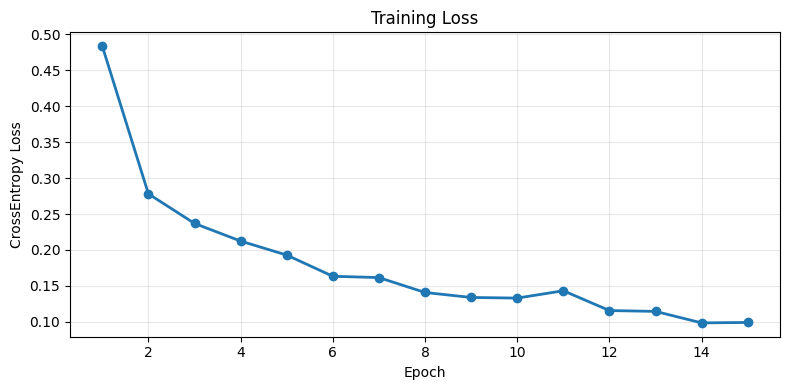

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCHS + 1), losses, marker="o", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy Loss")
plt.title("Training Loss")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Predictions After Fine-tuning

Side-by-side: OAM image | OSM ground truth | model prediction.
Fresh batch from the same dataloader (small dataset, so some overlap expected).

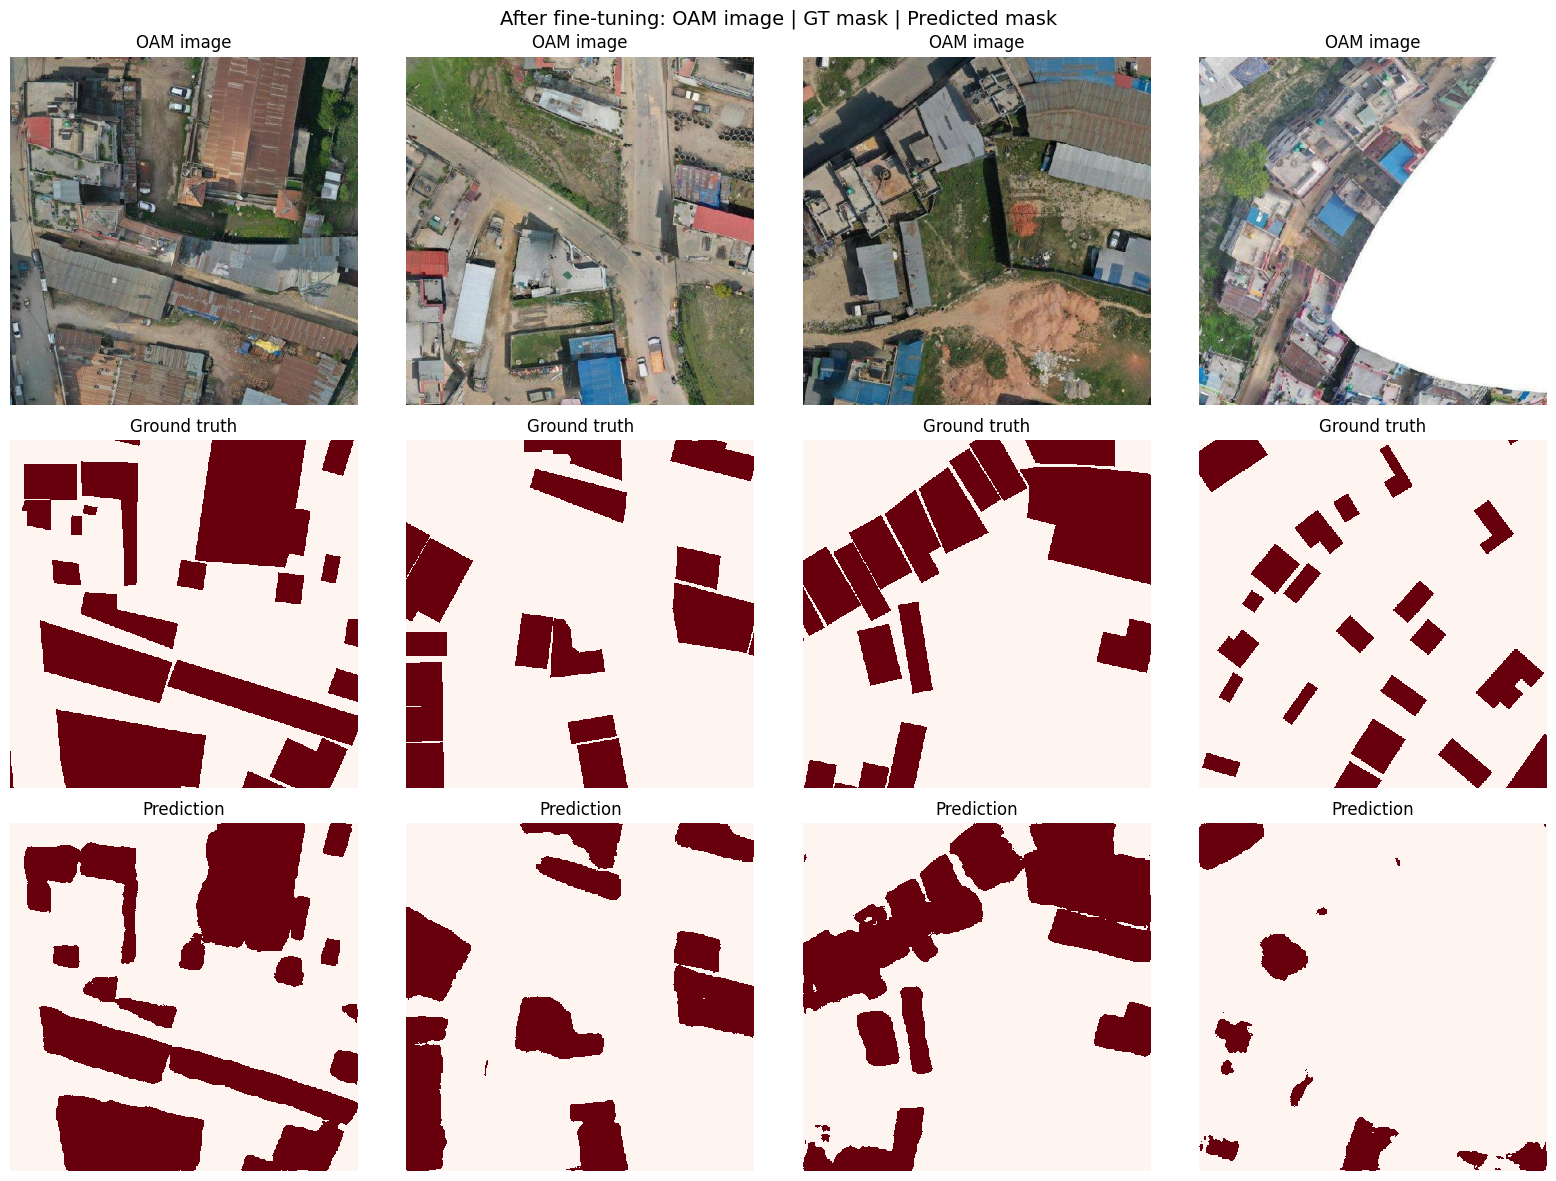

In [12]:
model.eval()
eval_batch = next(iter(dataloader))

with torch.no_grad():
    images = eval_batch["image"].to(DEVICE).float() / 255.0
    logits = model(images)
    preds = logits.argmax(dim=1).cpu().numpy()

masks = eval_batch["mask"].squeeze(1).numpy()

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i in range(min(4, len(eval_batch["image"]))):
    axes[0, i].imshow(eval_batch["image"][i].permute(1, 2, 0).byte().cpu().numpy())
    axes[0, i].set_title("OAM image")
    axes[0, i].axis("off")

    axes[1, i].imshow(masks[i], cmap="Reds", interpolation="nearest")
    axes[1, i].set_title("Ground truth")
    axes[1, i].axis("off")

    axes[2, i].imshow(preds[i], cmap="Reds", interpolation="nearest")
    axes[2, i].set_title("Prediction")
    axes[2, i].axis("off")

plt.suptitle("After fine-tuning: OAM image | GT mask | Predicted mask", fontsize=14)
plt.tight_layout()
plt.show()

## Save Fine-tuned Weights

In [ ]:
save_path = "building_unet_resnet50.pth"
torch.save(model.state_dict(), save_path)
print(f"Saved to {save_path} ({os.path.getsize(save_path) / 1e6:.1f} MB)")
